# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
#Download data and unzip it
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!ls
!unzip -q Cat_Dog_data.zip
!rm Cat_Dog_data.zip*
!ls

--2019-12-08 20:33:18--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.117
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  35.3MB/s    in 17s     

2019-12-08 20:33:40 (33.4 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]

Cat_Dog_data.zip  sample_data
Cat_Dog_data  __MACOSX	sample_data


Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [0]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [4]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 31.9MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [0]:
# Training on GPU:
# model.to('cuda')
# images = images.to('cuda')
# labels = labels.to('cuda')

# Train on CPU
# model.to('cpu')
# images = images.to('cpu')
# labels = labels.to('cpu')

In [0]:
import time

In [8]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 3.914 seconds
Device = cuda; Time per batch: 0.010 seconds


Well, so much for that. In the instructional video, however, we get a CPU training time of ~5.6 sec whereas on GPUs we get ~0.012 seconds.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Update the classifier portion of the network
# to suite our needs (2 outputs)
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.classifier = classifier

# Make sure the model is trained on the GPU
model.to(device)

# Setup the training information
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

print('Training the model...')

# Train
epochs = 5
train_losses, test_losses = [0]*epochs, [0]*epochs
for e in range(epochs):

    running_loss = 0

    # Loop on training images
    for images, labels in trainloader:

        # Move to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Iterate
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Keep track of loss
        running_loss += loss.item()

    else:

        accuracy = 0
        validation_loss = 0

        with torch.no_grad():
            model.eval()

            # Loop on testing data
            for images, labels in testloader:

                # Move to GPU
                images = images.to(device)
                labels = labels.to(device)

                # Compute stats
                log_ps = model(images)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

                # Compute the loss on the training set
                validation_loss += criterion(log_ps, labels).item()

    model.train()

    train_losses[e] = running_loss / len(trainloader)
    test_losses[e]  = validation_loss / len(testloader)

    print(f'Epoch {e}')
    print(f'   Accuracy  : {100*accuracy/len(testloader)}')
    print(f'   Train loss: {train_losses[e]}')
    print(f'   Test loss : {test_losses[e]}')

Training the model...
Epoch 0
   Accuracy  : 96.796875
   Train loss: 0.23459963489916513
   Test loss : 0.0818875940516591
Epoch 1
   Accuracy  : 96.875
   Train loss: 0.18003213439475407
   Test loss : 0.07235900154337287
Epoch 2
   Accuracy  : 95.8203125
   Train loss: 0.17391851236408745
   Test loss : 0.11253780638799071
Epoch 3
   Accuracy  : 97.3828125
   Train loss: 0.16747363463086498
   Test loss : 0.06240914396476001
Epoch 4
   Accuracy  : 97.1875
   Train loss: 0.15784830890003254
   Test loss : 0.06466477639041841


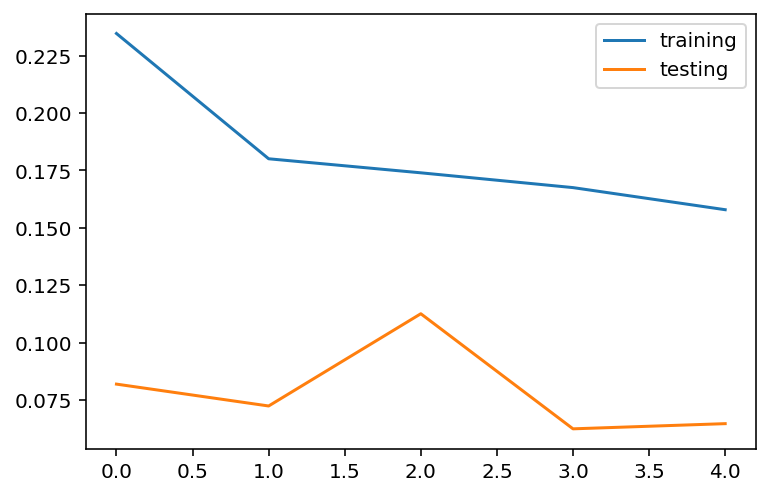

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training')
plt.plot(test_losses, label='testing')
plt.legend();

**NOTE**: The above was trained on Google Colab on a GPU. This ensured that I would be able to produce a fit model in a reasonable amount of time.